In [88]:
# @title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import unicodedata
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from math import e
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import f1_score
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from collections import Counter
import ast
import random
import json
from math import isnan

plt.rc('font', family='Times New Roman', size='20')

# %config InlineBackend.figure_format='retina'


rcParams['figure.figsize'] = 24, 16


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

token = '19e8eec1bcb4772464561a9dfa2e2dd0eec9c3e89557852b31592287'
import tushare as ts

In [89]:
ts.set_token(token)
pro = ts.pro_api()

csi300 = pro.index_daily(ts_code='399300.SZ')
csi300 = csi300.loc[('20210101' < csi300.trade_date) & (csi300.trade_date < '20211201')]
xin9 = pro.index_global(ts_code='XIN9', start_date='20210101', end_date='20211201')
new_xin9 = pd.DataFrame()
for index, row in csi300.iterrows():

    if row.trade_date in xin9.trade_date.values:
        new_xin9.loc[index, 'trade_date'] = row.trade_date
        price = xin9.loc[xin9.trade_date == row.trade_date, 'close'].values[0]
        new_xin9.loc[index, 'close'] = price
    else:
        new_xin9.loc[index, 'trade_date'] = row.trade_date
        new_xin9.loc[index, 'close'] = price
xin9 = new_xin9

csi300 = csi300.sort_index(ascending=False)
csi300 = csi300.reset_index(drop=True)
csi300.trade_date = pd.to_datetime(csi300.trade_date)
xin9 = xin9.sort_index(ascending=False)
xin9 = xin9.reset_index(drop=True)
xin9.trade_date = pd.to_datetime(xin9.trade_date)

In [90]:

df_test = pd.read_csv("../data/df_all_year_srl.csv", sep='\t')

df_test = df_test.drop(
    columns=['A0', 'A1', 'verbA0A1', 'verb_mask', 'A0_mask', 'A1_mask', 'AV_num'])
df_test.SECOND_DAY = pd.to_datetime(df_test.SECOND_DAY)
df_test.day1 = pd.to_datetime(df_test.day1)
df_test.day2 = pd.to_datetime(df_test.day2)
df_test.day3 = pd.to_datetime(df_test.day3)
df_test.day4 = pd.to_datetime(df_test.day4)
df_test.day5 = pd.to_datetime(df_test.day5)

In [91]:
df_test

,CODE,NAME,DATE,CREATED_DATE,text_a,DESCRIPTION,READ,MARKET,CHANGE,FIRST_DAY,...,open5,close5,day5,verb,trade_date,open_close_chg,co_label,cc_label,stock_factors,label
0,600006,东风汽车,2021-04-02 16:37:00,2021-04-02 16:33:00,东风汽车公告，3月汽车销量为2.31万辆，上年同期为1.37万辆，同比增长68.74%；一季...,东风汽车公告，3月汽车销量为2.31万辆，上年同期为1.37万辆，同比增长68.74%；一季...,4155194.0,1.0,0.003175,2021-04-02,...,6.1249,6.0754,2021-04-13,"[(13, 1), (24, 1), (33, 2), (47, 1), (56, 2)]",2021-04-02,0.134491,0.0,1.0,"[-0.3020583603065712, -0.2981298667692732, -0....",1
1,601880,大连港,2021-01-11 18:47:00,2021-01-11 18:47:00,营口港公告，公司发布了《营口港务股份有限公司关于大连港股份有限公司换股吸收合并公司并募集配套...,营口港公告，公司发布了《营口港务股份有限公司关于大连港股份有限公司换股吸收合并公司并募集配套...,5379661.0,1.0,0.000000,2021-01-11,...,1.8763,1.8763,2021-01-26,"[(8, 2), (33, 2), (35, 2), (42, 2), (87, 2), (...",2021-01-11,0.210301,2.0,3.0,"[-0.3868333706631927, -0.3828631887629431, -0....",1
2,2271,东方雨虹,2021-02-07 16:55:00,2021-02-07 16:55:00,东方雨虹公告，非公开发行股票申请获得中国证监会核准批文。,东方雨虹公告，非公开发行股票申请获得中国证监会核准批文。,5442991.0,0.0,-0.014683,2021-02-05,...,53.8267,50.0665,2021-02-22,"[(16, 2)]",2021-02-05,-1.108554,0.0,1.0,"[0.5756114363380322, 0.5596214058343731, 0.558...",1
3,603486,科沃斯,2021-01-18 18:26:00,2021-01-18 18:18:00,科沃斯公告，公司持股4.12%的股东泰怡凱電器有限公司拟减持不超过1693.10万股，即不超...,科沃斯公告，公司持股4.12%的股东泰怡凱電器有限公司拟减持不超过1693.10万股，即不超...,5457064.0,1.0,-0.045938,2021-01-18,...,115.6828,117.6671,2021-01-26,"[(8, 2), (26, 1), (41, 2)]",2021-01-18,-3.260698,0.0,0.0,"[1.8006385305400538, 1.7302126454124178, 1.655...",1
4,600319,ST亚星,2021-01-17 19:21:00,2021-01-17 19:20:00,ST亚星公告，公司收上交所问询函，此前公司称拟终止筹划重大资产重组暨签订现金收购景芝酒业白酒...,ST亚星公告，公司收上交所问询函，此前公司称拟终止筹划重大资产重组暨签订现金收购景芝酒业白酒...,5456051.0,1.0,-0.049869,2021-01-15,...,5.6100,5.6100,2021-01-25,"[(8, 4), (20, 2), (22, 2), (24, 2), (37, 2), (...",2021-01-15,-3.283389,4.0,4.0,"[-0.2663411732838291, -0.2732655989281695, -0....",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17888,628,高新发展,2021-08-27 20:52:00,2021-08-27 20:52:00,财联社8月27日电，高新发展公告，公司全资子公司成都倍特建筑安装工程有限公司与四川省建筑设计...,财联社8月27日电，高新发展公告，公司全资子公司成都倍特建筑安装工程有限公司与四川省建筑设计...,4394295.0,0.0,0.008413,2021-08-27,...,8.4900,8.5700,2021-09-06,"[(58, 1), (99, 2), (112, 1), (122, 2), (131, 1)]",2021-08-27,0.400751,2.0,2.0,"[-0.3200691712073005, -0.3204622358242249, -0....",1
17889,2982,湘佳股份,2021-05-07 19:40:00,2021-05-07 19:40:00,湘佳股份公告，公司2021年4月销售活禽298.95万只，销售收入6138.70万元，销售均...,湘佳股份公告，公司2021年4月销售活禽298.95万只，销售收入6138.70万元，销售均...,4120895.0,0.0,0.004317,2021-05-07,...,44.9100,44.3900,2021-05-17,"[(13, 2), (52, 6), (77, 1), (110, 2), (117, 1)...",2021-05-07,0.247811,0.0,1.0,"[0.4058399063708051, 0.4076937866227962, 0.427...",1
17890,600781,ST辅仁,2021-08-31 15:10:00,2021-08-30 20:13:00,财联社8月30日电，ST辅仁发布半年报，上半年归属于母公司所有者的净利润亏损2.94亿元，上...,财联社8月30日电，ST辅仁发布半年报，上半年归属于母公司所有者的净利润亏损2.94亿元，上...,3798845.0,1.0,-0.050139,2021-08-31,...,3.4700,3.5100,2021-09-08,"[(12, 2), (21, 3), (34, 2), (73, 2)]",2021-08-31,-4.001741,0.0,0.0,"[-0.4058427750124316, -0.4087848325644312, -0....",1
17891,2118,紫鑫药业,2021-09-29 17:17:00,2021-09-29 17:10:00,财联社9月29日电，紫鑫药业公告，预计2021年前三季度归属于上市公司股东的净亏损3.05亿...,财联社9月29日电，紫鑫药业公告，预计2021年前三季度归属于上市公司股东的净亏损3.05亿...,3915476.0,0.0,-0.003846,2021-09-29,...,2.7000,2.7100,2021-10-14,"[(16, 2), (24, 3), (53, 2), (69, 3), (96, 2), ...",2021-09-29,-0.663851,2.0,2.0,"[-0.4173456507942006, -0.4166161358913181, -0....",1


In [92]:
def string_to_tuples_list(text):
  if text is np.nan or text =='[]':
    return []
  text = text.strip('[').strip(']')
  tmp = text.split(' ')
  while '' in tmp:
    tmp.remove('')
  tmp = [*map(float,tmp)]
  return tmp

def keep_by_threshold(probability,threshold = 0.3):
    for prob in probability:
        if prob>threshold:
            return True
    return False

In [93]:
files = ['StockNet_ood.csv','HAN_ood.csv','Pretrained_RoBERT_ood.csv','Factor24_Pretrained_RoBert_SRL(FC)_V_ood.csv']

prediction_list = []
for file in files:
    prediction = pd.read_csv(file, sep='\t', index_col=None)
    prediction = prediction.drop_duplicates()
    prediction.probability = prediction.probability.apply(string_to_tuples_list)
    prediction = prediction.loc[prediction.probability.apply(keep_by_threshold)]
    prediction = prediction.reset_index(drop=True)
    
    prediction = df_test.merge(prediction, left_on='text_a', right_on='text').drop(columns=['Unnamed: 0'])
    prediction = prediction.sort_values('DATE').reset_index(drop=True)
    prediction.DATE = pd.to_datetime(prediction.DATE)
    prediction_list.append(prediction)

In [95]:
def back_test(df, df_prediction, number):
    deposit = 1
    total_lending = 0
    total_hold = 0
    portfolio = pd.DataFrame()
    commission_fee_rate = 0.0013
    total = deposit
    days = ['SECOND_DAY', 'day1', 'day2', 'day3', 'day4', 'day5']

    price = ['original_price', 'close1', 'close2', 'close3', 'close4', 'close5']
    total_list = []
    long_weight = [0, 0, 0, 0, 0]
    short_weight = [0, 0, 0, 0, 0]
    stay_weight = [0, 0, 0, 0, 0]
    name = 'prediction'
    reverse = 0
    reverse_bool = False
    for date_idx, date in df.iterrows():
        long_weight_i = [0]
        short_weight_i = [0]
    
        df_tmp = df_prediction.loc[df_prediction.SECOND_DAY == date.trade_date]
        df_tmp = df_tmp.reset_index(drop=True)
        
        df_tmp.loc[df_tmp[name]==0,name] = 3
        df_tmp.loc[df_tmp[name]==2,name] = 0
        df_tmp.loc[df_tmp[name]==3,name] = 2

        for p_idx, p in portfolio.iterrows():
            loss_stop_sign = False
            for i in range(1, 4):
                if p[days[i]] == date.trade_date:
                    #                     print(p_idx,i)
                    if p[name] == 0:
                        total_lending = total_lending + p[price[i]] * p['share'] - p[price[i - 1]] * p['share']
                        if p[price[i]] / p[price[0]] - 1 >= 0.05:
                            short_weight_i.append(1 - p[price[i]] / p[price[0]])
                            deposit = deposit - p.share * p[price[i]] * (1 + commission_fee_rate)
                            total_lending = total_lending - p.share * p[price[i]]
                            loss_stop_sign = True
                            portfolio = portfolio.drop(p_idx)

                    elif p[name] == 2:
                        #                         print(p_idx,i)
                        total_hold = total_hold + p[price[i]] * p['share'] - p[price[i - 1]] * p['share']
                        if p[price[i]] / p[price[0]] - 1 <= -0.05:
                            long_weight_i.append(p[price[i]] / p[price[0]] - 1)
                            deposit = deposit + p.share * p[price[i]] * (1 - commission_fee_rate)
                            total_hold = total_hold - p.share * p[price[i]]
                            loss_stop_sign = True
                            portfolio = portfolio.drop(p_idx)
                    break

            if p[days[number]] == date.trade_date and (not loss_stop_sign):
                if p[name] == 0:
                    short_weight_i.append(1 - p[price[i]] / p[price[0]])
                    deposit = deposit - p.share * p[price[number]] * (1 + commission_fee_rate)
                    total_lending = total_lending - p.share * p[price[number]]
                elif p[name] == 2:
                    deposit = deposit + p.share * p[price[number]] * (1 - commission_fee_rate)
                    total_hold = total_hold - p.share * p[price[number]]
                    long_weight_i.append(p[price[i]] / p[price[0]] - 1)
                portfolio = portfolio.drop(p_idx)

        long_weight.append(np.mean(long_weight_i))
        short_weight.append(np.mean(short_weight_i))
        if long_weight[len(long_weight) - 1] < 0 and short_weight[len(short_weight) - 1] < 0:
            stay_weight.append(-long_weight[len(long_weight) - 1] / 2 - short_weight[len(short_weight) - 1] / 2)
        else:
            stay_weight.append(0)
        
        long_divider = 1
        short_divider = 1
        if len(df_tmp.loc[df_tmp[name] == 0]) != 0:
            short_divider = 1 / len(df_tmp.loc[df_tmp[name] == 0])
        if len(df_tmp.loc[df_tmp[name] == 2]) != 0:
            long_divider = 1 / len(df_tmp.loc[df_tmp[name] == 2])
        weight_st = pow(50, sum(stay_weight[-3:]))
        weight_l = pow(50, sum(long_weight[-3:]))
        weight_sh = pow(50, sum(short_weight[-3:]))
        base = deposit - total_lending
        
        if len(total_list)>=3:
            if total_list[-1]/total_list[-2]-1 <= -0.03:
                reverse_bool = not reverse_bool
                reverse = 3
            if -0.002 < total_list[-1]/total_list[-2]-1 < 0.002 and -0.002 < total_list[-2]/total_list[-3]-1 < 0.002:
                weight_st = weight_st*2
        if reverse > 0 and reverse_bool:
            reverse -= 1
            if reverse ==0 :
                reverse_bool = False

            df_tmp[name]=1
        for stock_idx, stock in df_tmp.iterrows():
            l = stock.probability[2]
            sh = stock.probability[0]
            st = stock.probability[1]
            
            share_long = weight_l*l / (weight_l*l + weight_sh*sh + weight_st*st) * (base) / stock.original_price * long_divider
            share_short = weight_sh*sh / (weight_l*l + weight_sh*sh + weight_st*st) * (base) / stock.original_price * short_divider
            
            if stock[name] == 0:
                deposit = deposit + share_short * stock.original_price
                total_lending += share_short * stock.original_price
                stock['share'] = share_short
            elif stock[name] == 2 and deposit > 0.45:
                deposit = deposit - share_long * stock.original_price
                total_hold = total_hold + share_long * stock.original_price
                stock['share'] = share_long
            else:
                continue

            portfolio = portfolio.append(stock)
        portfolio = portfolio.reset_index(drop=True)
        
        total = total_hold + deposit - total_lending
        total_list.append(total)
    return total_list

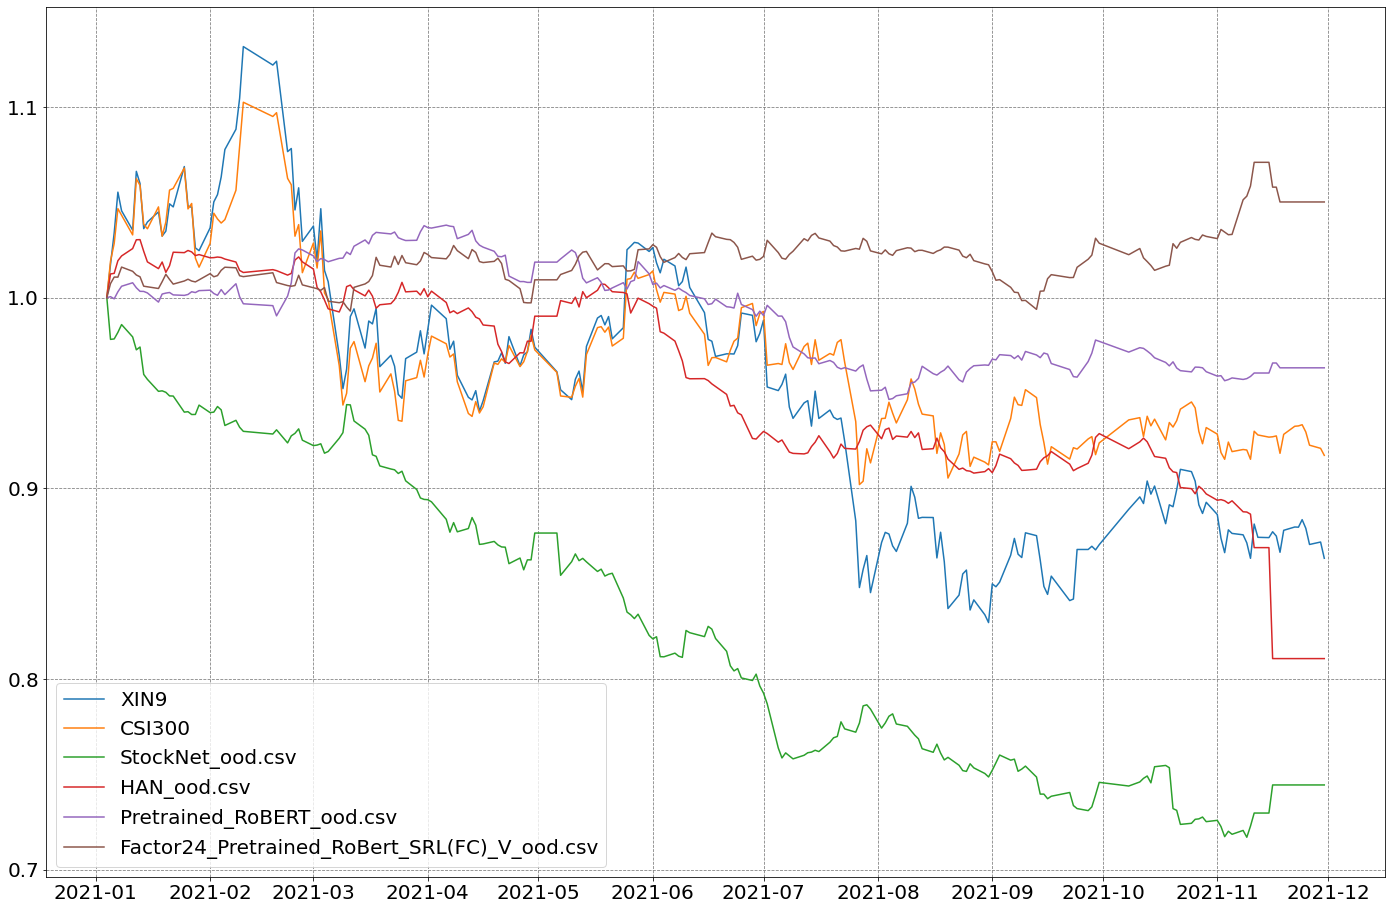

In [96]:
day = 1

x = csi300.trade_date.values
xin = (xin9.close / xin9.close[0]).values
csi = (csi300.close / csi300.close.loc[0]).values

prediction_results = [xin, csi]
for prediction in prediction_list:
    prediction_results.append(back_test(csi300, prediction, day))

files_name = ['XIN9', 'CSI300'] + files
for index, result in enumerate(prediction_results):
    plt.plot(x, result, label=files_name[index])
plt.grid(color='grey', linestyle='--')
plt.legend()
plt.show()

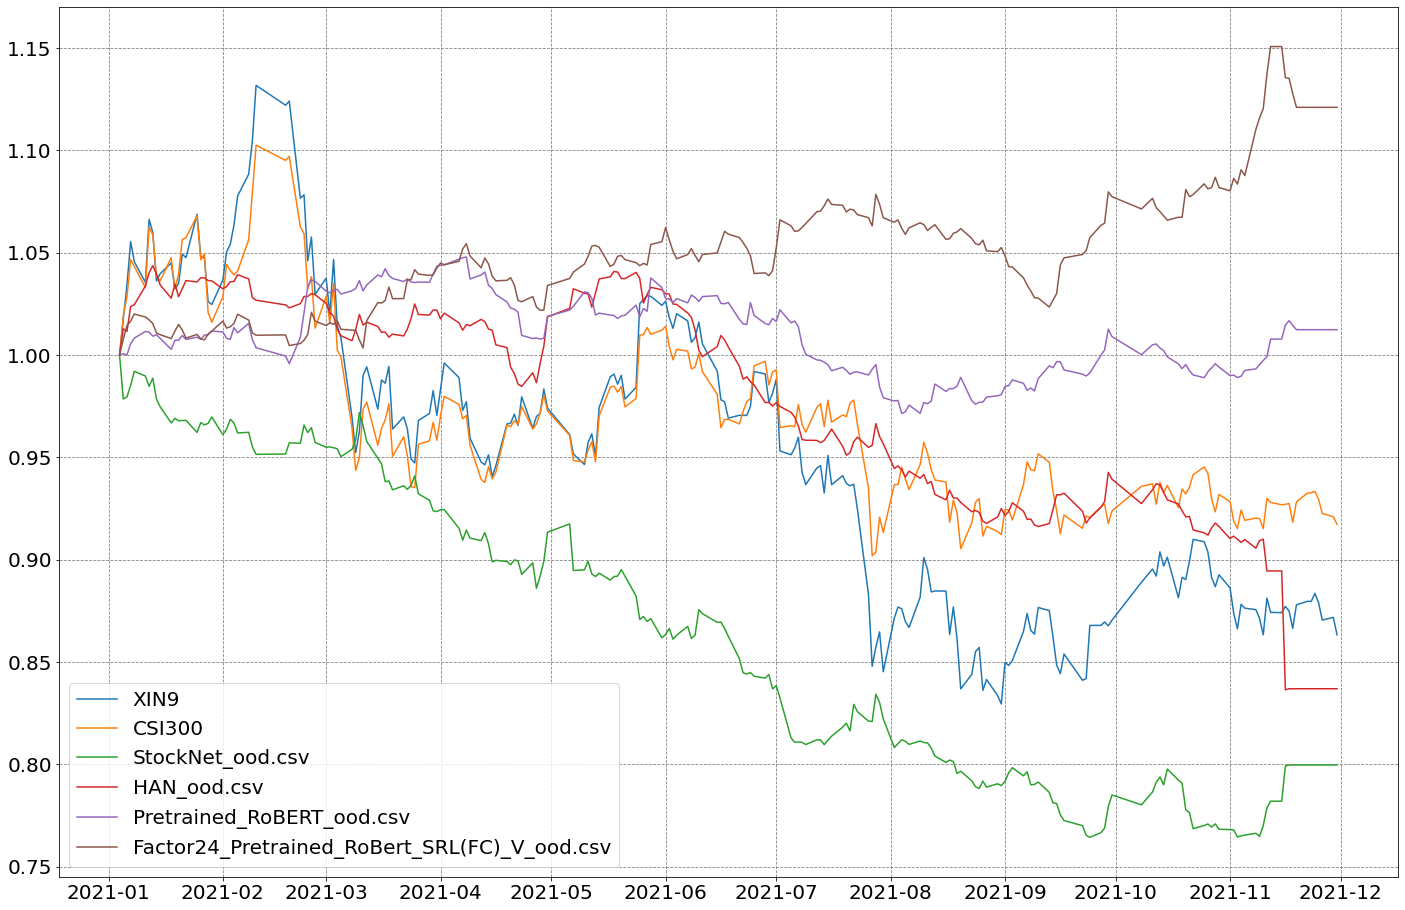

In [97]:
day = 2

x = csi300.trade_date.values
xin = (xin9.close / xin9.close[0]).values
csi = (csi300.close / csi300.close.loc[0]).values

prediction_results = [xin, csi]
for prediction in prediction_list:
    prediction_results.append(back_test(csi300, prediction, day))

files_name = ['XIN9', 'CSI300'] + files
for index, result in enumerate(prediction_results):
    plt.plot(x, result, label=files_name[index])
plt.grid(color='grey', linestyle='--')
plt.legend()
plt.show()

In [99]:
result= [x]

In [100]:
result.extend(prediction_results)

In [123]:
result_df = pd.DataFrame(result).T

In [117]:
result_df.columns = {'date','XIN9', 'CSI300', 'StockNet','HAN','Roberta-wwm-EXT', 'SRLP+SRL+Factor'}

In [118]:
result_df.to_csv('data_for_Dr_lin.csv')

In [119]:
files_name = ['XIN9', 'CSI300'] + files

## annualized rate of return

Total return:  [-0.1366917  -0.08270984 -0.20026055 -0.1630307   0.01236498  0.12098136]
Anual return:  [-0.153822901925611, -0.09344528935847207, -0.22426350219432667, -0.18309807764573116, 0.014062921205385104, 0.13857543239488312]


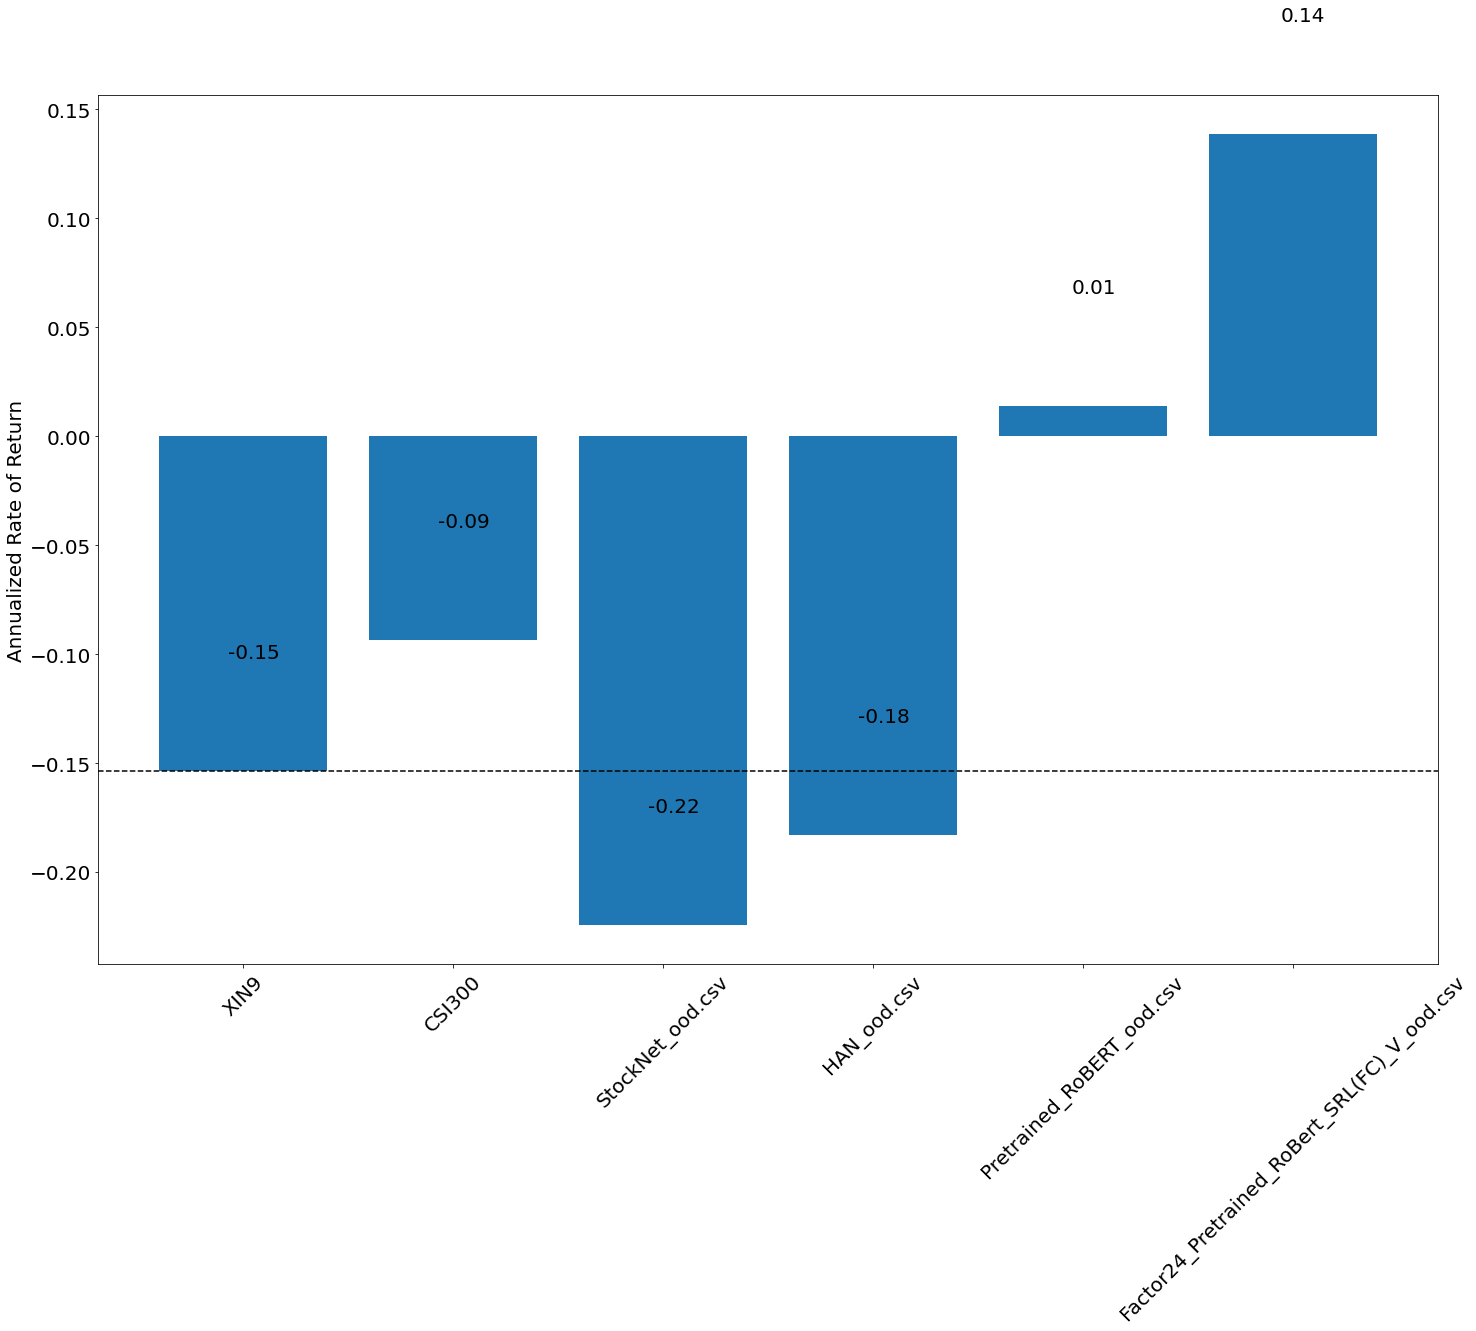

In [108]:
def anual_rate(total):
    return pow(total,(250/len(x)))-1

y_b = []
for prediction in prediction_results:
    y_b.append(prediction[-1])
print('Total return: ',np.array(y_b)-1)
y_b = [*map(anual_rate,y_b)]
print('Anual return: ',y_b)
plt.bar(files_name,y_b)
plt.axhline(y_b[0], color="black", linestyle="--")
plt.xticks(rotation=45)
plt.ylabel("Annualized Rate of Return")
for a,b in zip(range(len(files_name)),y_b):
    plt.text(a+0.05,b+0.05,'%.2f' %b, ha='center',va='bottom')

## 回撤

In [121]:
def drawdown(y,period):
    drawdown = 0
    drawdown_list = []
    max_drawdown = 0
    
    for i in range(period):
        price_tmp = y[0:i+1]
        max_price = np.max(price_tmp)
        max_index = np.argmax(price_tmp)
        min_price = np.min(price_tmp[max_index:i+1])
        if min_price/max_price-1 < drawdown:
            drawdown = min_price/max_price -1
            if drawdown< max_drawdown:
                max_drawdown = drawdown
        drawdown_list.append(drawdown)
        
    for i in range(len(y)-period):
        drawdown = 0
        price = y[i:i+period]
        for i in range(period):
            price_tmp = price[0:i+1]
            max_price = np.max(price_tmp)
            max_index = np.argmax(price_tmp)
            min_price = np.min(price_tmp[max_index:i+1])
            if min_price/max_price-1 < drawdown:
                drawdown = min_price/max_price -1
                if drawdown< max_drawdown:
                    max_drawdown = drawdown
        drawdown_list.append(drawdown)
        
    return max_drawdown, drawdown_list

period =  20

drawdown_list = []
for index,name in enumerate(files_name):
    dd = drawdown(prediction_results[index],period)
    print(name,dd[0])
    drawdown_list.append(dd[1])

XIN9 -0.15855256296281595
CSI300 -0.14407027709036424
StockNet_ood.csv -0.07402097391861129
HAN_ood.csv -0.09188829806299836
Pretrained_RoBERT_ood.csv -0.03839904918137127
Factor24_Pretrained_RoBert_SRL(FC)_V_ood.csv -0.03608344432610244


In [125]:
x
a = [x]
a.extend(drawdown_list)
drawback_df = pd.DataFrame(a).T

,0,1,2,3,4,5,6
0,2021-01-04,0,0,0,0,0,0
1,2021-01-05,0,0,-0.021488,0,0,0
2,2021-01-06,0,0,-0.021488,-0.00128,-0.00061,0
3,2021-01-07,0,0,-0.021488,-0.00128,-0.00061,0
4,2021-01-08,-0.009261,-0.003306,-0.021488,-0.00128,-0.00061,0
...,...,...,...,...,...,...,...
215,2021-11-24,-0.032927,-0.017857,-0.008264,-0.088691,-0.006779,-0.025793
216,2021-11-25,-0.032927,-0.017857,-0.008264,-0.088691,-0.006779,-0.025793
217,2021-11-26,-0.032927,-0.017857,-0.004902,-0.087037,-0.005155,-0.025793
218,2021-11-29,-0.025941,-0.014226,-0.004678,-0.082311,-0.004339,-0.025793


In [115]:

drawback_df.columns = {'date','XIN9', 'CSI300','StockNet', 'HAN','Roberta-wwm-EXT', 'SRLP+SRL+Factor'}
drawback_df.to_csv('drawback_for_Dr_lin.csv')

,date,SRLP+SRL+Factor,StockNet,CSI300,XIN9,HAN,Roberta-wwm-EXT
0,2021-01-04,0,0,0,0,0,0
1,2021-01-05,0,0,-0.021488,0,0,0
2,2021-01-06,0,0,-0.021488,-0.00128,-0.00061,0
3,2021-01-07,0,0,-0.021488,-0.00128,-0.00061,0
4,2021-01-08,-0.009261,-0.003306,-0.021488,-0.00128,-0.00061,0
...,...,...,...,...,...,...,...
215,2021-11-24,-0.032927,-0.017857,-0.008264,-0.088691,-0.006779,-0.025793
216,2021-11-25,-0.032927,-0.017857,-0.008264,-0.088691,-0.006779,-0.025793
217,2021-11-26,-0.032927,-0.017857,-0.004902,-0.087037,-0.005155,-0.025793
218,2021-11-29,-0.025941,-0.014226,-0.004678,-0.082311,-0.004339,-0.025793


In [192]:
drawdown_list.extend(prediction_results)

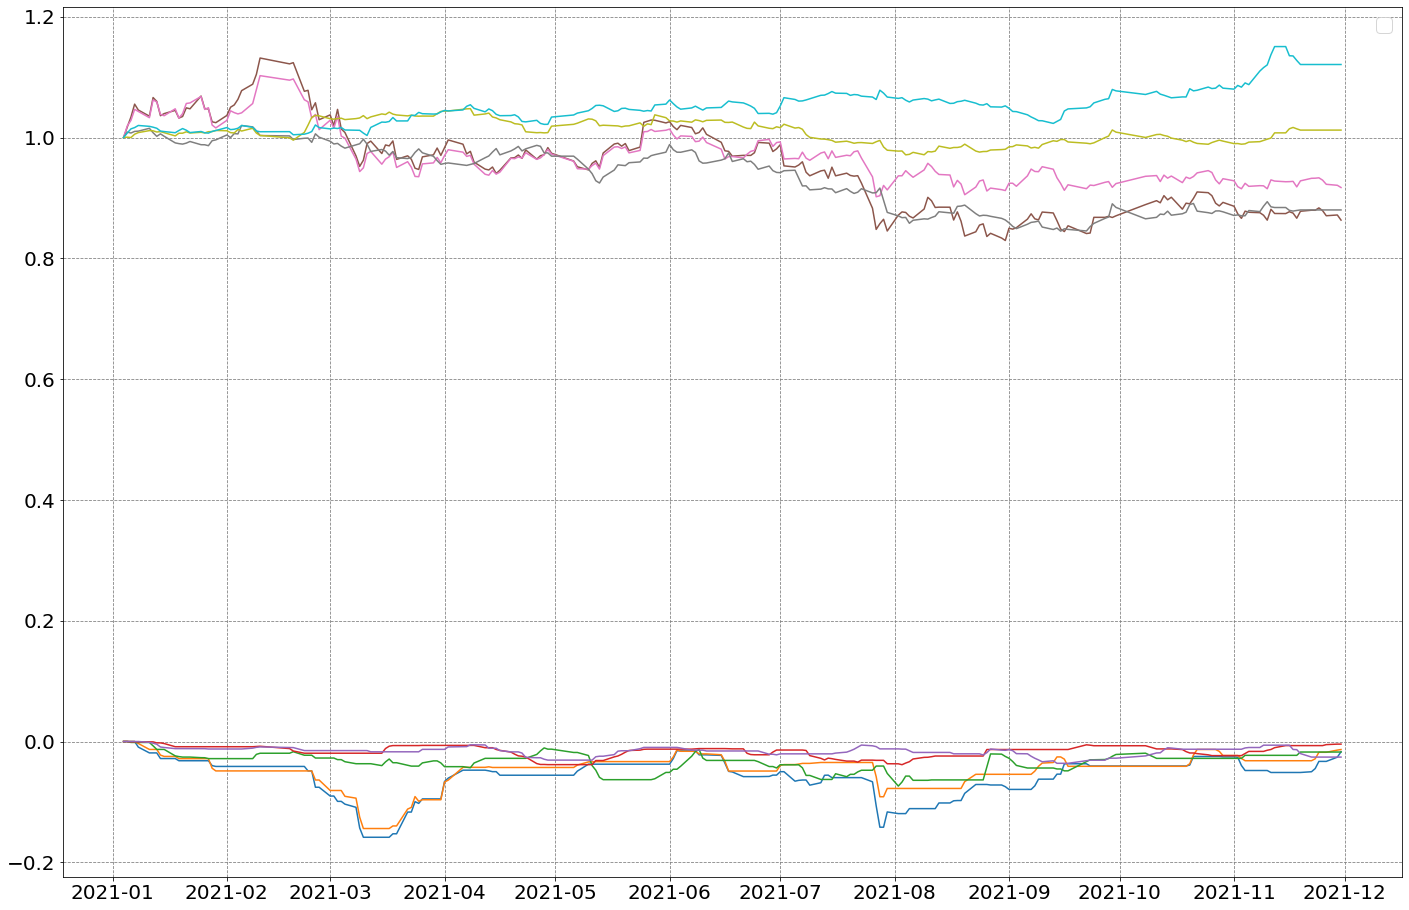

In [194]:
for index, result in enumerate(drawdown_list):
    plt.plot(x, result)
plt.grid(color='grey', linestyle='--')
plt.legend()
plt.ylim((-2, 2))
plt.show()

## Sharp Ratio

In [191]:
def sharp_ratio(y,period,risk_free):
    sharp_ratio_list = []
    risk_free_period = pow(1+risk_free,period/250)-1
    for i in range(period,len(y),period):
        sharp_ratio_list.append(y[i]-y[i-period])
    return(np.mean(np.array(sharp_ratio_list)-risk_free_period)/np.std(sharp_ratio_list))

period = 20
risk_free_ratio = 0.03
for index,name in enumerate(files_name):
    print(name,sharp_ratio(prediction_results[index],period,risk_free_ratio))


XIN9 -0.32017413653813726
CSI300 -0.3299969456646372
HAN_ood.csv -0.558433268891132
Pretrained_RoBERT_ood.csv -0.1631457109573599
Factor24_Pretrained_RoBert_SRL(FC)_V_ood.csv 0.40936872087215487
